# Task 4: Group Task

### Spain as country

In [59]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from rasterio.plot import show
from shapely.ops import unary_union
import rasterio
import atlite

In [60]:
file = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
shapes = gpd.read_file(file).set_index('name')

In [61]:
spain = shapes.query("index == 'ES'").to_crs(3035).geometry
spain.explore()

In [62]:
regions = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-ESP.gpkg"
regions = gpd.read_file(regions)

In [63]:
regions =regions.drop(12,13)

C:\Users\leoni\AppData\Local\Temp\ipykernel_11880\3660186539.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  regions =regions.drop(12,13)


ValueError: No axis named 13 for object type GeoDataFrame

In [ ]:
regions

### create 5 zones for the analysis:

In [ ]:
zone1 = regions.drop(range(1,17))
zone1 = unary_union(zone1.geometry)

#comunidad valencia, castilla la mancha, extremadura, madrid
zone2 = regions.drop([0,1,2,4,5,6,8,11,14,15,16,17])
zone2 = unary_union(zone2.geometry)

#cataluna und aragon
zone3 = regions.drop([0,2,3,4,6,7,8,9,10,11,14,15,16,17])
zone3 = unary_union(zone3.geometry)

#8,14,15,4,16,2
zone4 = regions.drop([0,1,3,5,6,7,9,10,11,17])
zone4 = unary_union(zone4.geometry)

zone5 = regions.drop([0,1,2,3,4,5,6,7,8,9,10,14,15,16,17])
zone5 = unary_union(zone5.geometry)

geometries = [zone1,zone2,zone3,zone4,zone5]
names = ['zone_1','zone_2','zone_3','zone_4','zone_5',]


In [ ]:
zones = gpd.GeoDataFrame(names, geometry = geometries)
zones['center'] = zones.geometry.centroid

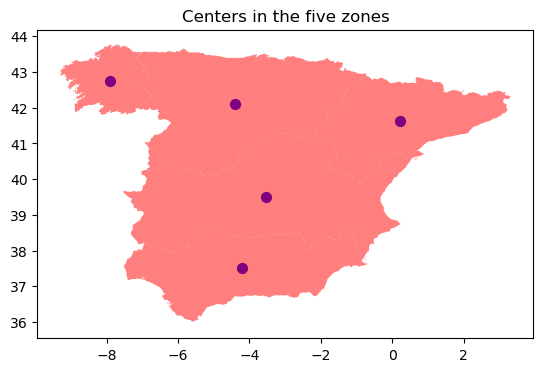

In [64]:
fig, ax = plt.subplots()

# Plot the points
zones.center.plot(ax=ax, color='blue', markersize=50)
point_color = (1, 0, 0, 0.5)
zones.geometry.plot(ax=ax, color=point_color )
ax.set_title("Centers in the five zones")

# Display the plot
plt.show()

### First, perform a land eligibility analysis
- onshore wind:
- 10km distance to airports
- 300m distance to major roads
- no natural protection areas
- maximum elevation of 2000m
- 1000m distance to built up areas
- only on suitable land cover classes

In [65]:
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [66]:
file_roads = 'ne_10m_roads.gpkg'
file_airport = 'ne_10m_airports.gpkg'
file_clases = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
#file_elevation = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-ES.nc'
file_elevation = 'GEBCO_2014_2D-ES.nc'
file_protected = 'WDPA_Oct2022_Public_shp-ESP.tif'
weather_data = 'era5-2020-ES.nc'
area = spain

In [67]:
spain

name
ES    MULTIPOLYGON (((3368439.798 2321843.493, 33692...
Name: geometry, dtype: geometry

In [68]:
#exclude roads and airports:
excluder = ExclusionContainer(crs=3035,res =500) #delete 'res' when its working
clc = rasterio.open(file_clases)
band = clc.read()

<Axes: >

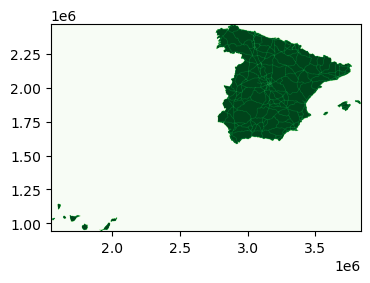

In [69]:
#roads
excluder.add_geometry(file_roads, buffer = 300)
band, transform = shape_availability(area, excluder)
fig, ax = plt.subplots(figsize=(4,5))
zones.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

<Axes: >

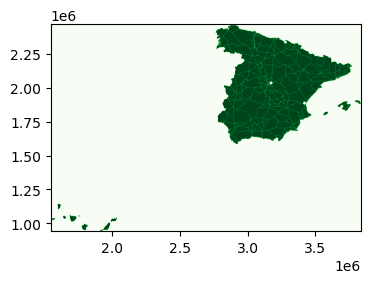

In [70]:
#airports
excluder.add_geometry(file_airport, buffer = 10000)
band, transform = shape_availability(area, excluder)
fig, ax = plt.subplots(figsize=(4,5))
zones.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

<Axes: >

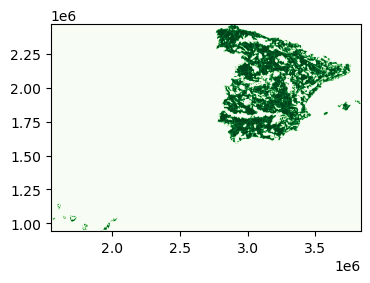

In [71]:
#exclude natural protected areas
excluder.add_raster(file_protected,crs=3035)
masked, transform = shape_availability(area, excluder)
fig, ax = plt.subplots(figsize=(4,5))
zones.plot(ax=ax, color='none')
show(masked, transform=transform, cmap='Greens', ax=ax)

In [78]:
#elevation higher than 2000m:???
excluder.add_raster(file_elevation, codes = lambda x: x<2000, crs = 4326, invert=True)
masked, transform = shape_availability(area, excluder)
fig, ax = plt.subplots(figsize=(4,5))
zones.plot(ax=ax, color='none')
show(masked, transform=transform, cmap='Greens', ax=ax)

AttributeError: 'CRS' object has no attribute 'is_valid'

In [ ]:
#land clases

### Offshore Wind
- within EEZ
- up to water depth of 50m
- no natural protection areas
- 10km minimum distance to shore

In [48]:
# Load EEZ
EEZ = gpd.read_file("eez_v11.gpkg")

# Extract EEZ of Spain and change CRS
EEZ_Spa = EEZ[EEZ['GEONAME'] == 'Spanish Exclusive Economic Zone']
EEZ_Spa = EEZ_Spa.to_crs(3035)

<Axes: >

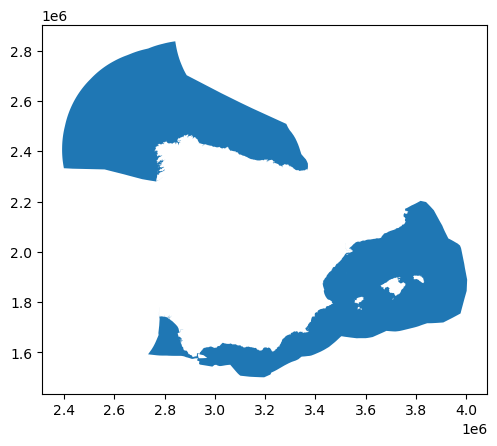

In [51]:
EEZ_Spa.geometry.plot()

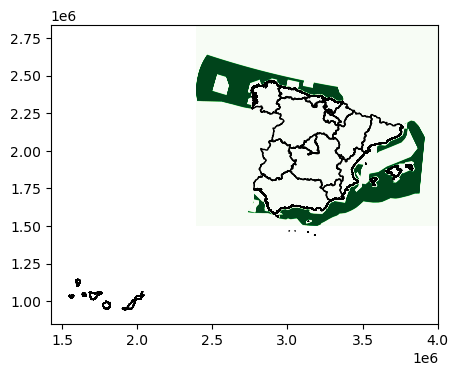

In [77]:
# Land eligibility for offshore wind
# define excluder to get eligible area
excluder_offwind = ExclusionContainer(crs=3035, res=300)

# Exclude protected areas
fn = file_protected
excluder_offwind.add_raster(fn, crs=3035)

#Exclude 10km  distance to shore
excluder_offwind.add_geometry(regions, buffer=10000)

# Exclude elevation < -50 m
fn = file_elevation
excluder_offwind.add_raster(fn, codes= lambda x: x>-50, crs=4326)

masked, transform = shape_availability(EEZ_Spa.geometry, excluder_offwind)
plot_area(masked, transform, regions.to_crs(3035).geometry)

### Second, using atlite download historical weather data from the ERA5 dataset into an atlite.
Cutout as shown in the lecture for a year of your choice and the geographical bounds of your selected country (add a buffer of 0.25 degrees).
Then, together with the availability matrix and the corresponding atlite conversion functions, calculate
the wind and solar capacity factor time series per modelled region.
For offshore wind, use a "NREL_ReferenceTurbine_5MW_offshore" as reference turbine.

In [79]:
cutout = atlite.Cutout('era5-2020-ES.nc')
cutout.data

<xarray.Dataset>
Dimensions:           (x: 53, y: 34, time: 8784)
Coordinates:
  * x                 (x) float64 -9.5 -9.25 -9.0 -8.75 ... 2.75 3.0 3.25 3.5
  * y                 (y) float64 35.75 36.0 36.25 36.5 ... 43.5 43.75 44.0
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(53,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(34, 53), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'influx', 'wind', 'runoff', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-07-12 16:45:58 GMT by grib_to_netcdf-2.25.1: /op...

#### use "NREL_ReferenceTurbine_5MW_offshore" as reference turbine
- hubhight 90m 
- assume z_0 for Open sea = 0.0002

In [81]:
wnd100m = cutout.data.wnd100m.mean(dim='time')

<GeoAxes: xlabel='x', ylabel='y'>

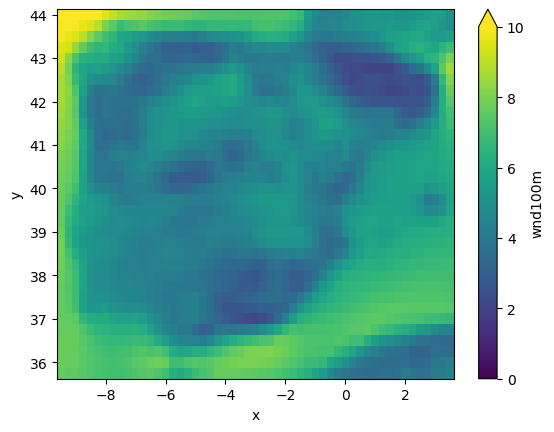

In [94]:
#ax = plt.axes(projection=ccrs.EPSG(3035))

wnd100m.plot(vmin=0, vmax=10)

EEZ_Spa.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [97]:
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m

In [99]:
wnd90m = wnd100m * np.log(90 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

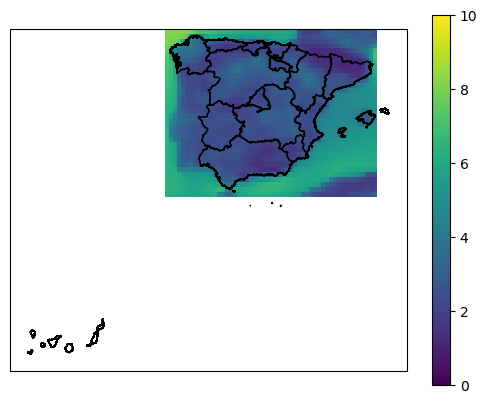

In [101]:
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd90m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
regions.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [80]:
A_offwind = cutout.availabilitymatrix(regions, excluder_offwind)

Compute availability matrix: 100%|█████████████████████████████████████████████| 18/18 [00:33<00:00,  1.87s/ gridcells]


### Solar (rooftop & utility)
- only on suitable land cover classes
- no natural protection areas

### land cover clases: 

0:  no valid input data
20: Shrubs
30: herbaceous vegetation
40: Cultivated and managed vegetation/agriculture (cropland)
60: bare/sparse vegetation
90: Herbaceous wetland
50: Urban / built up

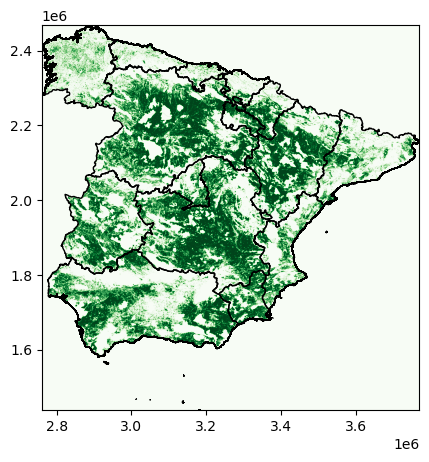

In [40]:
# Solar land eligibility

# Define excluder to get eligible area
excludersolar = ExclusionContainer(crs=3035, res=300)

# Only include suitable land classes
fn = file_clases
codes_solar=[0,20,30,40,60,90]
excludersolar.add_raster(fn, codes=codes_solar, crs=4326, invert=True)
# Exclude protected areas
fn = file_protected
excludersolar.add_raster(fn, crs=3035)
# Compute eligible area for solar
masked, transform = shape_availability(regions.to_crs(3035).geometry, excludersolar)
# Plot eligible area
# function to plot the exclusions (from excercise: Preparation for Group Assignment)

plot_area(masked, transform, regions.to_crs(3035).geometry)


## Second, using atlite download historical weather data from the ERA5 dataset into an atlite. 

Cutout as shown in the lecture for a year of your choice and the geographical bounds of your selected country (add a buffer of 0.25 degrees).

In [21]:
cutout = atlite.Cutout('era5-2020-ES.nc')
cutout.data

<xarray.Dataset>
Dimensions:           (x: 53, y: 34, time: 8784)
Coordinates:
  * x                 (x) float64 -9.5 -9.25 -9.0 -8.75 ... 2.75 3.0 3.25 3.5
  * y                 (y) float64 35.75 36.0 36.25 36.5 ... 43.5 43.75 44.0
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(53,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(34, 53), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'influx', 'wind', 'runoff', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-07-12 16:45:58 GMT by grib_to_netcdf-2.25.1: /op...

<Axes: >

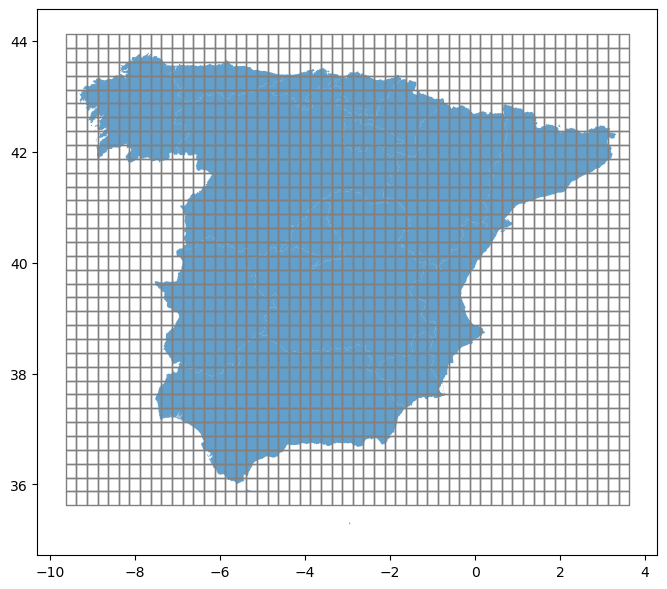

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
regions.to_crs(4326).plot(ax=ax,alpha = 0.7,)
cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

In [30]:
A_onsolar = cutout.availabilitymatrix(regions, excludersolar)

Compute availability matrix: 100%|█████████████████████████████████████████████| 16/16 [00:03<00:00,  4.28 gridcells/s]


In [31]:
#from isis course rasterio part  
cap_per_sqkm = 3

# Comppute area of provinces
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
# Compute onwind capacity matrix

capacity_matrix_solar = A_onsolar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

NameError: name 'xr' is not defined